In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
from preprocessing_lib import get_modified_current, get_currents_with_constant_dt 
import mod_trace
from kylie2017IKr import Kylie2017IKr

import simulator_myokit
import vc_protocols_for_myokit

C:\Anaconda3\envs\ml\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Anaconda3\envs\ml\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


Kylie dataset has been selected.
(9, 2)


In [2]:
sys.path.append(f'../../../../Dataset/herg25oc1_real_data_nx1540') # herg25oc1_real_data_nx1540
from getdata import get_dataset, get_times

In [3]:
def MSE(y, y_pred, axis=1):
	return np.mean(np.square(y - y_pred), axis=axis)

In [4]:
# dir_path = './Results'
# try:
#     if not os.path.exists(dir_path):
#         os.makedirs(dir_path)
#         print('"%s" has been created.'%(dir_path))
#     else:
#         print("The folder already exists.")
# except OSError:
#     print('Error: create_folder(). : ' + dir_path)

In [5]:
# for i in range(5):
# xs, ys = get_dataset(file_numbers=range(1, 3), multi=True, use_torch=True)

# xs, ys = get_dataset(file_numbers=range(1, 31), window=10, step_size=5, multi=False, use_torch=False, get_raw=False)

cell_to_remove=['A04', 'A15', 'E05', 'E22', 'G10', 'G22', 'H08', 'I10', 'I12', 'I16', 'L08', 'P15', 'P18' ] # M24
cell_to_remove=[]

xs, ys, cells = get_dataset(cell_to_remove=cell_to_remove, scale=50, multi=True, torch_tensor=False)  # <-- fast
times = get_times(scale=50)
print(xs.shape, ys.shape, times.shape)

The number of full cells : 210
The number of removed Cells : 0
The number of cells : 210
--- 7.381864309310913 seconds ---
(210, 1540) (210, 9) (1540,)


In [19]:
test_index = 27
test_current = xs[test_index]
test_params = ys[test_index]
test_cell = cells[test_index]
print(f"Test cell : {test_cell}")
print(test_current.shape, test_params.shape)

Test cell : B20
(1540,) (9,)


In [42]:
dt = 0.01 #0.0002
t_eval = np.arange(1540)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())
t_span

(0, 15.39)

In [43]:
start_time = time.time()

# hERG model settings
temperature = 25.0
temperature += 273.15  # in K
fit_seed = '542811797'
withfcap = False

m_myokit, protocol, script = myokit.load("../../../mmt-model-files/kylie-2017-IKr.mmt" )
m_myokit.get('phys.T').set_rhs(temperature)
# Set concentration
m_myokit.get('potassium.Ko').set_rhs(float(4.0))
m_myokit.get('potassium.Ki').set_rhs(float(110.0))

protocol = vc_protocols.leak_staircase()

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

print("--- %s seconds ---"%(time.time()-start_time))

--- 7.4765625 seconds ---


In [44]:
'''
simulation for experimental data
'''
start_time = time.time()

parameters = { 
    'ikr.g' : test_params[0],
    'ikr.p1' : test_params[1],
    'ikr.p2' : test_params[2],
    'ikr.p3' : test_params[3],
    'ikr.p4' : test_params[4],
    'ikr.p5' : test_params[5],
    'ikr.p6' : test_params[6],
    'ikr.p7' : test_params[7],
    'ikr.p8' : test_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol_real_sim = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent1 = {
    'O': sol_real_sim['ikr.open']*sol_real_sim['ikr.active'],
    'I': sol_real_sim['ikr.open']*(1-sol_real_sim['ikr.active']),
    'C': (1-sol_real_sim['ikr.open'])*sol_real_sim['ikr.active'],
    'IC': (1-sol_real_sim['ikr.open'])*(1-sol_real_sim['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.02200150489807129 seconds ---


In [45]:
model_params_dir = "./Results-herg25oc1-staircaseramp-solution-CMAES-542811797-dt001"

In [46]:
'''
simulation for experimental data without noise-removal(nr)
'''
start_time = time.time()

file = os.path.join(model_params_dir, f"{test_cell}_prior_p8_u100_ui11_nrFalse.txt")
f = open(file, mode='r')
info = f.readlines()
sol1_params = []
for i in range(6, 15):
    sol1_params.append(float(info[i]))
sol1_params = np.array(sol1_params)
f.close() 

parameters = { 
    'ikr.g' : sol1_params[0],
    'ikr.p1' : sol1_params[1],
    'ikr.p2' : sol1_params[2],
    'ikr.p3' : sol1_params[3],
    'ikr.p4' : sol1_params[4],
    'ikr.p5' : sol1_params[5],
    'ikr.p6' : sol1_params[6],
    'ikr.p7' : sol1_params[7],
    'ikr.p8' : sol1_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol1 = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent1 = {
    'O': sol1['ikr.open']*sol1['ikr.active'],
    'I': sol1['ikr.open']*(1-sol1['ikr.active']),
    'C': (1-sol1['ikr.open'])*sol1['ikr.active'],
    'IC': (1-sol1['ikr.open'])*(1-sol1['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.019972562789916992 seconds ---


In [47]:
'''
simulation for experimental data with noise-removal(nr)
'''
start_time = time.time()

file = os.path.join(model_params_dir, f"{test_cell}_prior_p8_u100_ui11_nrTrue.txt")
f = open(file, mode='r')
info = f.readlines()
sol2_params = []
for i in range(6, 15):
    sol2_params.append(float(info[i]))
sol2_params = np.array(sol2_params)
f.close() 

parameters = { 
    'ikr.g' : sol2_params[0],
    'ikr.p1' : sol2_params[1],
    'ikr.p2' : sol2_params[2],
    'ikr.p3' : sol2_params[3],
    'ikr.p4' : sol2_params[4],
    'ikr.p5' : sol2_params[5],
    'ikr.p6' : sol2_params[6],
    'ikr.p7' : sol2_params[7],
    'ikr.p8' : sol2_params[8],
}

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
sol2 = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent2 = {
    'O': sol2['ikr.open']*sol2['ikr.active'],
    'I': sol2['ikr.open']*(1-sol2['ikr.active']),
    'C': (1-sol2['ikr.open'])*sol2['ikr.active'],
    'IC': (1-sol2['ikr.open'])*(1-sol2['ikr.active']),    
}

print("--- %s seconds ---"%(time.time()-start_time))

--- 0.026971817016601562 seconds ---


In [48]:
print(test_params)
print(sol1_params)
print(sol2_params)

[2.83902769e+04 2.44627824e-01 7.71100398e+01 3.02463930e-02
 4.79679588e+01 1.02466699e+02 1.33721352e+01 7.67093498e+00
 3.06798198e+01]
[2.839028e+04 2.446279e-01 7.711001e+01 3.024639e-02 4.796796e+01
 1.024667e+02 1.337213e+01 7.670933e+00 3.067982e+01]
[2.833378e+04 2.454181e-01 7.693590e+01 2.948368e-02 4.814514e+01
 1.033471e+02 1.331627e+01 7.744905e+00 3.063627e+01]


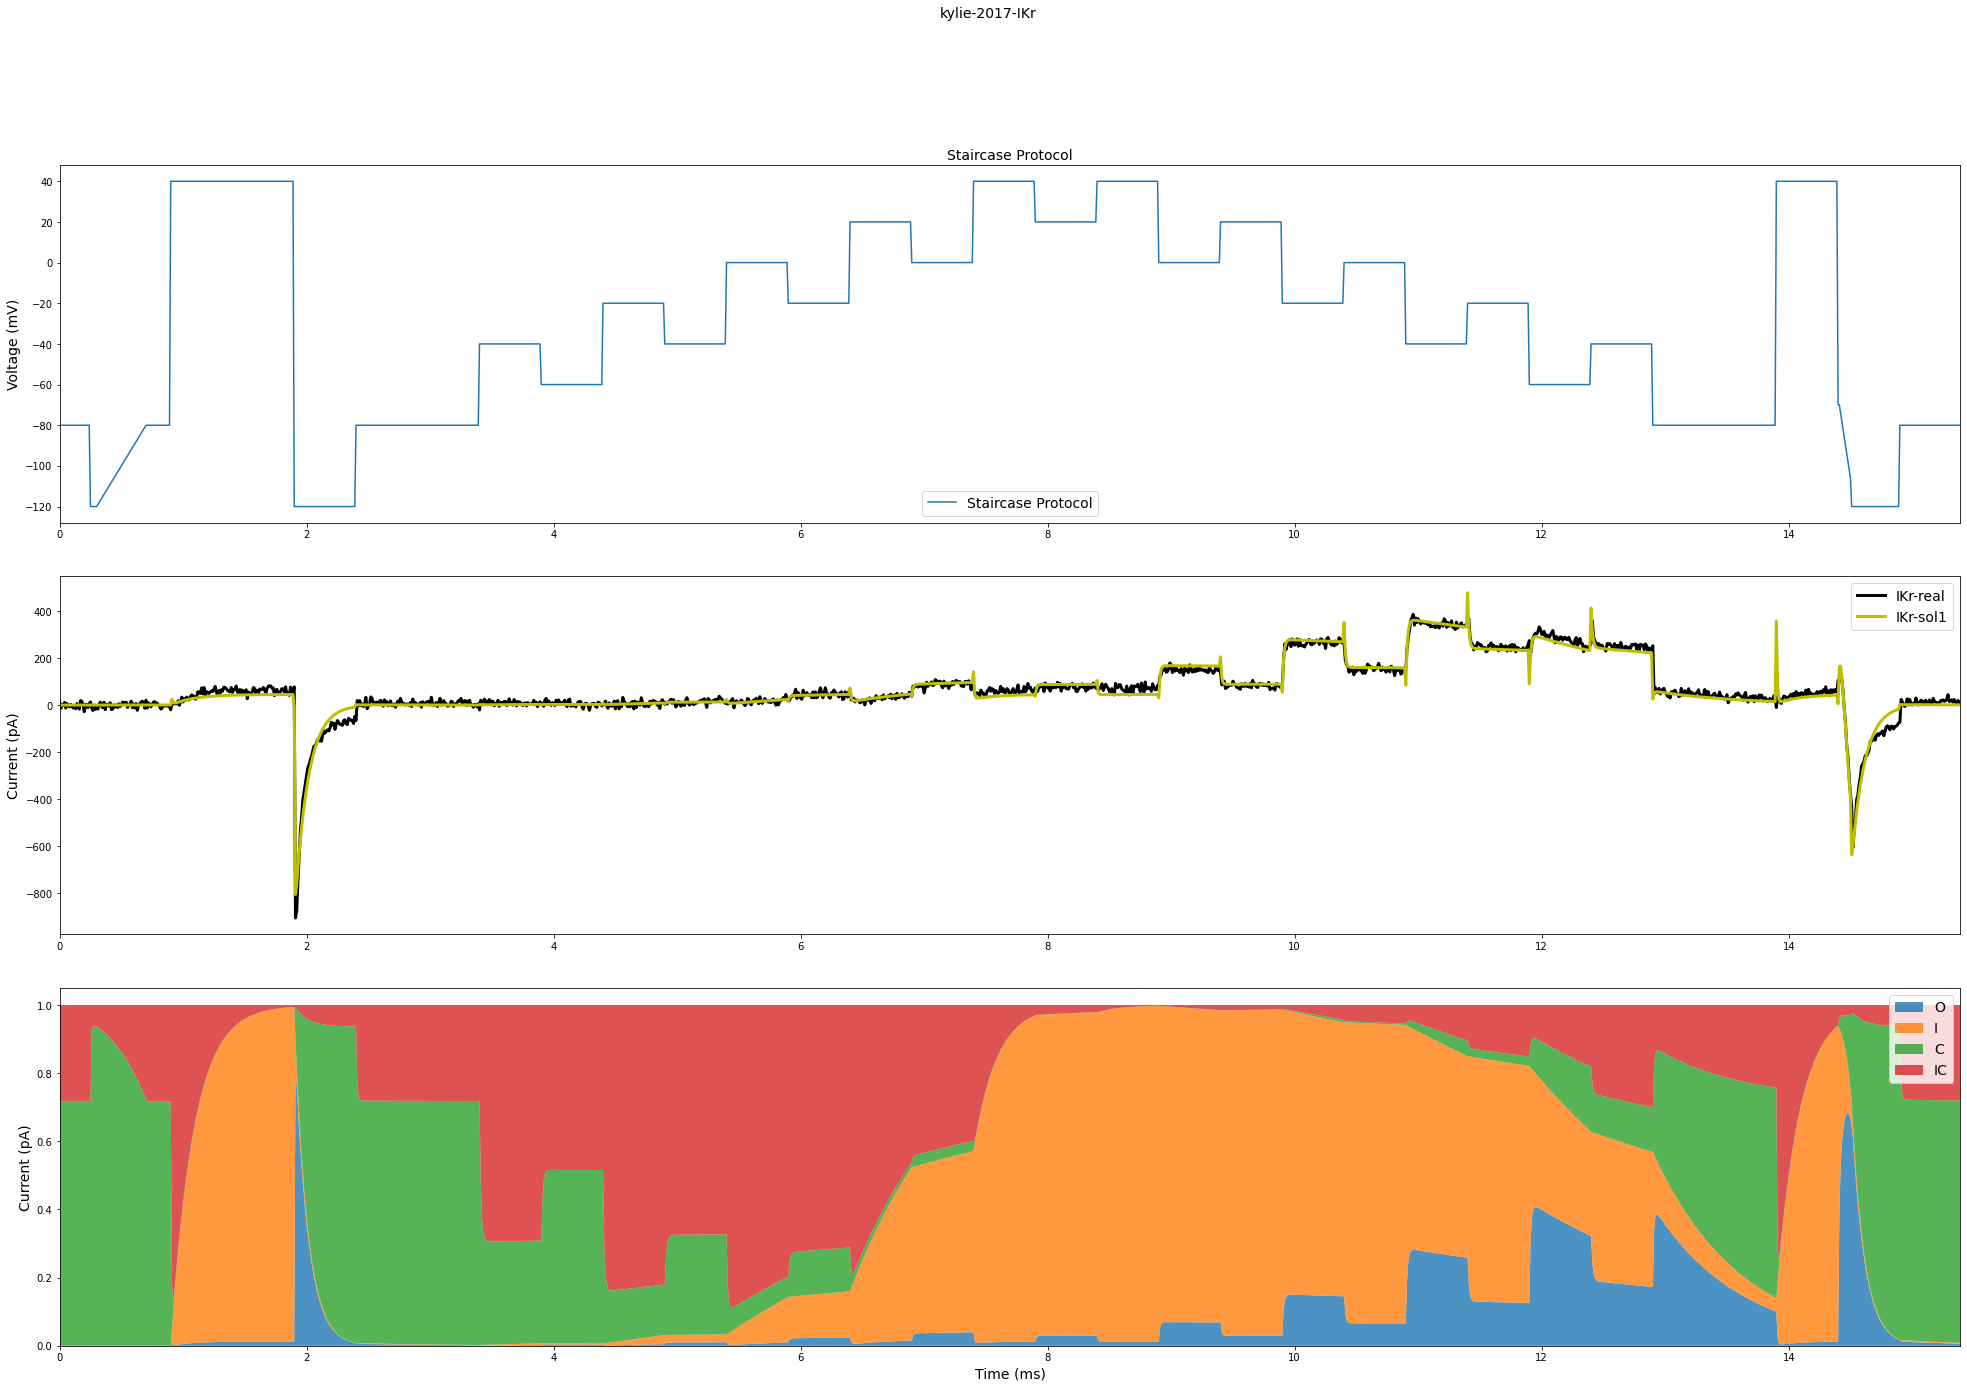

Complete


In [52]:
fig, axes = plt.subplots(3, figsize=(30, 20))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, t_eval[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( t_eval, sol_real_sim['membrane.V']*1000, label="Staircase Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, t_eval[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(times, test_current, label="IKr-real", linewidth=3, color='k')
# axes[1].plot(t_eval, sol_real_sim['ikr.IKr'], label="IKr-real-sim", linewidth=3, color='b')
axes[1].plot(t_eval, sol1['ikr.IKr'], label="IKr-sol1", linewidth=3, color='y')
# axes[1].plot(t_eval, sol2['ikr.IKr'], label="IKr-sol2", linewidth=1, color='r')
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, t_eval[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(t_eval, population_by_continent1.values(), labels=population_by_continent1.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
# fig.savefig(os.path.join('Results', 'Kylie2017IKr_VC.jpg'), dpi=100)
print("Complete")